## Pre-processing (object count)

### Notebook Purpose:

- For each object of interest: From a set of images of a single event, choose only one
- Save a parquet file with preprocessed data for each object, so object-specific analysis can happen in another Notebooks

In [5]:
#!pip install -r requirements.txt

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
from datetime import datetime
import numpy as np
from imutils import resize
import argparse
import cv2
import requests
import time
import base64
import os
from os.path import isfile, isdir, join
import uuid
import matplotlib.pyplot as plt
import pandas as pd
#from darkflow.net.build import TFNet
from pylab import rcParams
import random
from imutils import build_montages
from tqdm import *
import glob
import math
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.spatial import distance as dist
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def imshow(img, width=12, height=6):
    """
    Show image using matplotlib. Function takes a path or a 
    numpy image and renders it in RBG color-space
    """
    if isinstance(img, str):
        img = cv2.imread(img)
    rcParams['figure.figsize'] = width, height
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    plt.show()

In [3]:
def monshow(images_to_show, rows=3, cols=3, width=10, height=10):
    """Show montage of images in rows and columns"""
    montages = build_montages(images_to_show, (700, 420), (cols, rows))
    for montage in montages:
        imshow(montage, width, height)

In [4]:
def draw_boxes(img, boxes):
    colors = [(38,119,176),(177,222,143),(225,36,41),(252,190,118),
          (255,255,160),(55,74,93),(103,192,165),(165,205,225)]
    objects = ["dog", "person", "car", "cat", "bird", "bicycle", "motorbike", "truck"]
    colormap = dict(zip(objects, colors))
    img_cp = img.copy()
    legit_boxes_info = []
    for b in boxes:
        if b['label'] in objects:
            
            # Remove any cars parked right outside of the house,
            # the assumption here is that the bottomright y property will
            # be greater than 120 (for now)
            if b['label'] == 'car' and b['bottomright']['y'] > 120:
                continue
                
            x1, y1 = b['topleft']['x'], b['topleft']['y']
            x2, y2 = b['bottomright']['x'], b['bottomright']['y']
            cv2.rectangle(img_cp, (x1, y1), (x2, y2), colormap[b['label']], 2)
            
            # add data elements
            legit_boxes_info.append([b['label'], b['confidence'], x1, y1, x2, y2])
            
            #put text in the bottom or on top of the bounding box
            cv2.putText(img_cp, '{}-{:.1f}%'.format(b['label'], b['confidence']), 
                               (int(x1+4), int(y1+8)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 
                               1, cv2.LINE_AA)
    return img_cp, legit_boxes_info

### Join good images data after clean up and first look

Single row represents a sigle object detected in a frame, so we can have multiple records representing a single frame if multiple objects were detected

In [5]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df = df.sort_values('date_time', ascending=True)
df = df.drop(labels=['index'], axis=1)
df.head()

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
78,72919,car,0.683013,299,20,423,75,2019-09-09,05.20.54,05.20.54.048_5a365eb8_car.jpg,1,048,2019-09-09 05:20:54.048,Monday,False,9,5,20
279,73092,person,0.886713,270,184,439,339,2019-09-09,05.51.53,05.51.53.437_bb9a559e_person.jpg,1,437,2019-09-09 05:51:53.437,Monday,False,9,5,51
542,73337,person,0.879273,295,177,461,341,2019-09-09,05.51.53,05.51.53.614_2c112e1b_person.jpg,1,614,2019-09-09 05:51:53.614,Monday,False,9,5,51
44,72885,person,0.760198,327,141,476,341,2019-09-09,05.51.53,05.51.53.825_ec838624_person.jpg,1,825,2019-09-09 05:51:53.825,Monday,False,9,5,51
1624,74312,person,0.496198,417,103,509,312,2019-09-09,05.51.54,05.51.54.553_70aa8959_person.jpg,1,553,2019-09-09 05:51:54.553,Monday,False,9,5,51


In [6]:
df.shape

(657894, 18)

In [7]:
df['date'].min(), df['date'].max()

('2019-09-09', '2020-03-02')

In [8]:
df.sort_values('confidence', ascending=True).head()

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
355484,5482,person,0.380006,203,4,218,26,2019-12-23,15.01.53,15.01.53.425_deeaf9f2_person-person.jpg,2,425,2019-12-23 15:01:53.425,Monday,False,12,15,1
347606,31617,person,0.380018,157,0,170,19,2019-12-16,08.41.04,08.41.04.199_a5726939_person.jpg,2,199,2019-12-16 08:41:04.199,Monday,False,12,8,41
346310,30530,person,0.380044,559,30,578,69,2019-12-15,15.08.14,15.08.14.935_7f65daa0_person-car.jpg,3,935,2019-12-15 15:08:14.935,Sunday,True,12,15,8
366165,13359,person,0.380050,179,3,191,21,2019-12-24,10.50.43,10.50.43.779_e6a31246_person.jpg,2,779,2019-12-24 10:50:43.779,Tuesday,False,12,10,50
352505,2774,person,0.380055,70,148,114,226,2019-12-21,17.15.35,17.15.35.163_5a73e292_person.jpg,2,163,2019-12-21 17:15:35.163,Saturday,True,12,17,15


### Keep only a single frame from the event's frame sequence

Let's assume that we have a person walking along the footpath. We should assume that this person will be recognised in many frames, therefore many images of the same object will be captured.

Algorithm to solve this:
- sort data by time
- divide dataset by object type (label) and perform following tasks:
    - calculate difference in time between consecutive object observations
    - calculate euclidean distance between consecutive frames centroids (using x,y coordinates), if it's the same object, then the center will be close to the previous center
    - keep only objects where time and distance differences are greater than predefined thresholds (defined using heuristics)

In [9]:
df['label'].unique()

array(['car', 'person', 'truck', 'dog', 'bird', 'bicycle', 'cat',
       'motorbike'], dtype=object)

In [10]:
# dictionary holding a dataframe per predicted class
dfs = {}

In [11]:
# these values seem to reject duplicates the best
# NOTE: can this be learned from the data?
# NOTE2: this should be in a config file
THRESH_NEW_EVENT_SECS = 10
THRESH_NEW_EVENT_MIN_DISTANCE = 30

In [12]:
# use this function to calculate euclidean distance between coordinates
def calc_distance(x):
    x_cur, y_cur, x_prev, y_prev = x
    return dist.cdist([[x_cur, y_cur]], [[x_prev, y_prev]], metric='euclidean')[0][0]

In [15]:
# create a separate DataFrame for each label of interest and save as a csv file
for l in ['car', 'person', 'dog', 'cat', 'truck']:
    
    print('Processing label: {}'.format(l))
    
    # filter out other objects from the data frame
    analysed_label_df = df.loc[df['label'].isin([l])].reset_index(drop=True).copy()
    
    # add a dummy variable, which we can use to count objects,
    # there are most likely better ways of doing this, but this one is simple
    analysed_label_df['dummy_var'] = 1
    
    # calculate time difference between consecutive rows
    analysed_label_df['time_diff'] = analysed_label_df['date_time'].diff().fillna(pd.Timedelta(seconds=0))
    analysed_label_df['sec_diff'] = analysed_label_df['time_diff'].dt.total_seconds().fillna(0)
    analysed_label_df['x_center'] = analysed_label_df[['x1', 'x2']].mean(axis=1)
    analysed_label_df['y_center'] = analysed_label_df[['y1', 'y2']].mean(axis=1)

    # calculate euclidian distance between consecutive centroids (using x,y coordinates centroids)
    analysed_label_df['prev_x_center'] = analysed_label_df['x_center'].shift(1).fillna(0)
    analysed_label_df['prev_y_center'] = analysed_label_df['y_center'].shift(1).fillna(0)
    analysed_label_df['euc_distance'] = analysed_label_df[['x_center', 'y_center', 
        'prev_x_center', 'prev_y_center']].apply(calc_distance, axis=1)

    # keep only records within the rejection threshold
    idx = ((analysed_label_df['sec_diff'] > THRESH_NEW_EVENT_SECS) & 
           (analysed_label_df['euc_distance'] > THRESH_NEW_EVENT_MIN_DISTANCE))
    dfs[l] = analysed_label_df.loc[idx].reset_index(drop=True).copy()
    dfs[l].to_csv(f'../Datasets/UniqueObjectDetections__{l}__2019-09-09_2020-03-02.csv', index=False)

Processing label: car
Processing label: person
Processing label: dog
Processing label: cat
Processing label: truck


In [15]:
unique_obs_df = dfs['car']
unique_obs_df.head(5)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,74204,car,0.765957,551,42,606,75,2019-09-09,07.02.38,07.02.38.965_0353490f_car-car-car.jpg,1,965,2019-09-09 07:02:38.965,Monday,False,9,7,2,1,00:32:53.382000,1973.382,578.5,58.5,456.0,53.0,122.623407
1,74375,car,0.675785,111,2,226,26,2019-09-09,07.03.02,07.03.02.473_599df73a_car-car-car.jpg,1,473,2019-09-09 07:03:02.473,Monday,False,9,7,3,1,00:00:20.255000,20.255,168.5,14.0,89.5,11.5,79.039547
2,73090,car,0.515128,71,7,166,23,2019-09-09,07.13.23,07.13.23.268_84646f26_car-car-car.jpg,1,268,2019-09-09 07:13:23.268,Monday,False,9,7,13,1,00:10:18.653000,618.653,118.5,15.0,577.5,47.5,460.149161
3,72992,car,0.866409,373,34,504,118,2019-09-09,07.30.31,07.30.31.103_ffc1dea9_car-car.jpg,1,103,2019-09-09 07:30:31.103,Monday,False,9,7,30,1,00:17:04.296000,1024.296,438.5,76.0,587.0,60.5,149.306731
4,73234,car,0.837546,274,38,436,120,2019-09-09,08.08.23,08.08.23.248_7173a1f9_car.jpg,1,248,2019-09-09 08:08:23.248,Monday,False,9,8,8,1,00:37:50.165000,2270.165,355.0,79.0,536.5,67.0,181.896262


In [17]:
use_cols = ['label', 'confidence', 'date_time', 'week_day', 'month', 'hour', 'min', 'is_weekend']
unique_obs_df[use_cols].head(2)

,label,confidence,date_time,week_day,month,hour,min,is_weekend
0,car,0.765957,2019-09-09 07:02:38.965,Monday,9,7,2,False
1,car,0.675785,2019-09-09 07:03:02.473,Monday,9,7,3,False


### Analyse Yolo confidence

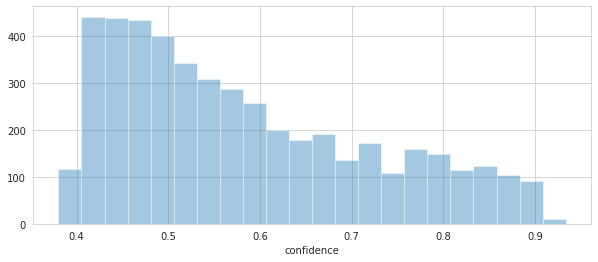

In [18]:
# out of curiosity, check confidence for analysed label
plt.figure(figsize=(10, 4))
sns.distplot(unique_obs_df['confidence'], kde=False);

We can see that Yolo is actually not that confident in the predictions

### Analyse dataset for a predefined time interval: 60 minutes

In [19]:
# define human readable field names to use below
dt_field, minute_interval = 'time_interval', '60min'

In [20]:
unique_obs_df[dt_field] = unique_obs_df['date_time'].dt.round(minute_interval)
unique_obs_df['hour'] = (unique_obs_df[dt_field].dt.hour).astype(str).str.zfill(2)
unique_obs_df[minute_interval] = (unique_obs_df[dt_field].dt.minute).astype(str).str.zfill(2)
unique_obs_df[f'hour_{minute_interval}'] = unique_obs_df['hour'] + '-' + unique_obs_df[minute_interval]
unique_obs_df.head(2)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance,time_interval,60min,hour_60min
0,74204,car,0.765957,551,42,606,75,2019-09-09,07.02.38,07.02.38.965_0353490f_car-car-car.jpg,1,965,2019-09-09 07:02:38.965,Monday,False,9,07,2,1,00:32:53.382000,1973.382,578.5,58.5,456.0,53.0,122.623407,2019-09-09 07:00:00,00,07-00
1,74375,car,0.675785,111,2,226,26,2019-09-09,07.03.02,07.03.02.473_599df73a_car-car-car.jpg,1,473,2019-09-09 07:03:02.473,Monday,False,9,07,3,1,00:00:20.255000,20.255,168.5,14.0,89.5,11.5,79.039547,2019-09-09 07:00:00,00,07-00


In [21]:
# calculate mean ob observations per day
unique_obs_df.groupby('date')['img_idx'].count().reset_index().sort_values('img_idx', ascending=False)['img_idx'].mean()

27.136363636363637

In [22]:
unique_obs_df.shape

(4776, 29)

### Count mean observations between predefined time intervals

In [23]:
# rename dummy_var to something more representative
unique_obs_df = unique_obs_df.rename(columns={'dummy_var': 'object_count'})

In [24]:
def resample_by_interval(df, date_time_field, minutes_interval, reset_index=True):
    resampled = (df
         .groupby([date_time_field])['object_count']
         .sum()
         .resample(minutes_interval)
         .sum()
         .reset_index())
    resampled['hour'] = (resampled[date_time_field].dt.hour).astype(str).str.zfill(2)
    resampled[minutes_interval] = (resampled[date_time_field].dt.minute).astype(str).str.zfill(2)
    resampled[f'{minutes_interval}_bucket'] = resampled['hour'] + '-' + resampled[minutes_interval]
    resampled = resampled.groupby(f'{minutes_interval}_bucket')['object_count'].mean()
    if reset_index == True:
        resampled = resampled.reset_index()
    return resampled

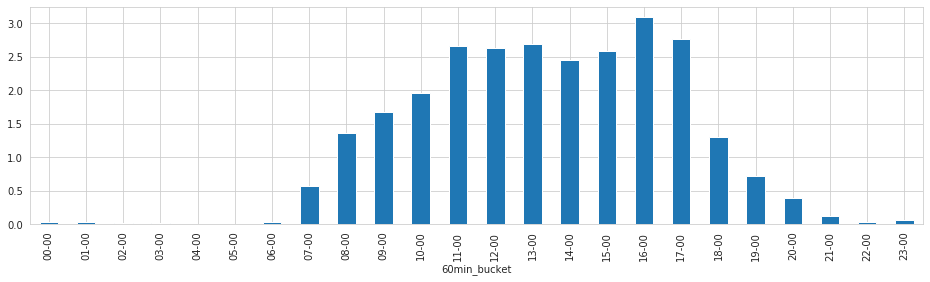

In [31]:
resampled = resample_by_interval(unique_obs_df, dt_field, minute_interval, False)
resampled.plot(figsize=(16, 4), kind='bar');

#### Note:

We can see **almost** a Gaussian distribution here

### Now break down by weekend / week-days

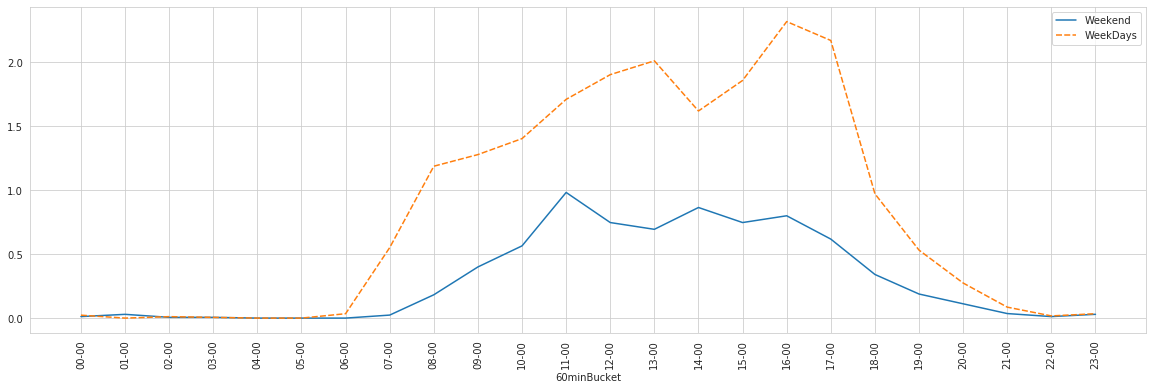

In [26]:
# resample weekend data
idx = unique_obs_df['is_weekend'] == True
filtered = unique_obs_df.loc[idx].copy()
resampled_mean_weekend = resample_by_interval(filtered, dt_field, minute_interval, True)

# resample non-weekend data
idx = unique_obs_df['is_weekend'] == False
filtered = unique_obs_df.loc[idx].copy()
resampled_mean_weekday = resample_by_interval(filtered, dt_field, minute_interval, True)

# merge dataframes
merged = (resampled_mean_weekend.merge(resampled_mean_weekday, on=f'{minute_interval}_bucket', 
                                        suffixes=('_Weekend', '_WeekDays')))
merged.columns = [f'{minute_interval}Bucket', 'Weekend', 'WeekDays']
merged = merged.set_index(f'{minute_interval}Bucket')

# plot
plt.figure(figsize=(20, 6))
ax = sns.lineplot(data=merged)
ax.set_xticklabels(merged.index, rotation=90);

### Analyse outliers

Here we can group by dataset by date and time interval. This will be the basis to verify the accuracy based on the historical data.

Then we can roll up this data to the time intervals only (drop the date field). We can use these averages as a crude way to generate the forecast based on the historical data.

**Important:**

Need to think about the actual data to include in the training/testing data samples. Since we can't really see any observations in the night hours, we should perhaps exclude these hours (like between 10PM and 5AM) from the dataset.

#### Note:
We could also use something like moving averages algorithm for the forecast baseline. I will leave it out for now, but if time permits I will come back to it and try several ways of using moving averages (with and without exponential smoothing for example).

In [32]:
# group data by date & time interval
resampled = (unique_obs_df
    .groupby([dt_field])['object_count']
    .sum()
    .resample(minute_interval)
    .sum()
    .reset_index())
resampled.tail(2)

,time_interval,object_count
4210,2020-03-02 17:00:00,7
4211,2020-03-02 18:00:00,5


In [33]:
resampled.shape

(4212, 2)

In [34]:
# add new features, which can be used for modelling
resampled['hour'] = resampled[dt_field].dt.hour
resampled['week'] = resampled[dt_field].dt.week
resampled['week_in_month'] = pd.to_numeric(resampled[dt_field].dt.day / 7)
resampled['week_in_month'] = resampled['week_in_month'].apply(lambda x: math.ceil(x))
resampled['month'] = resampled[dt_field].dt.month
resampled['day_of_week'] = resampled[dt_field].dt.weekday
resampled['is_weekend'] = ((resampled[dt_field].dt.weekday) // 5 == 1).astype(int)
resampled.head(2)

,time_interval,object_count,hour,week,week_in_month,month,day_of_week,is_weekend
0,2019-09-09 07:00:00,3,7,37,2,9,0,0
1,2019-09-09 08:00:00,2,8,37,2,9,0,0


#### Remove outages

In [38]:
resampled.shape

(4164, 8)

In [39]:
# first outage, storm - power outage
idx = (resampled['time_interval'] >= '2020-01-13 00:00:00') & (resampled['time_interval'] <= '2020-01-14 23:59:59')
resampled = resampled.loc[~idx]

# 2nd outage, issue with boiler, plumber disconnected a switch
# and services did not pick up themselves
idx = (resampled['time_interval'] >= '2020-03-03 00:00:00') & (resampled['time_interval'] <= '2020-03-07 23:59:59')
resampled = resampled.loc[~idx]

In [40]:
resampled.shape

(4164, 8)

### Find suspicious time intervals

These would be days without any observations or with huge number of observations

In [41]:
by_day = resampled.set_index('time_interval').groupby(pd.Grouper(freq='D'))['object_count'].sum()
by_day.reset_index().sort_values('object_count', ascending=True).head(5)

,time_interval,object_count
127,2020-01-14,0
126,2020-01-13,0
49,2019-10-28,7
146,2020-02-02,8
114,2020-01-01,10


Note: the first 2 days have been removed from the Frame, so it's fine

In [46]:
by_day.reset_index().sort_values('object_count', ascending=False).head(5)

,time_interval,object_count
21,2019-09-30,48
46,2019-10-25,47
37,2019-10-16,46
129,2020-01-16,45
24,2019-10-03,44


Note: Looks like we have a single very heavy day on 28 Feb. Need to take a look at the images from that day to understand what happened. It will most likely be cought as an outlier in the subsequent section of the analysis.

### Set X and y

In [143]:
# # uncomment to remove nighlty hours
# idx = (resampled['hour'] > 4) & (resampled['hour'] < 23)
# resampled_filtered = resampled.loc[idx].reset_index().copy()
# resampled_filtered.head(2)

In [43]:
# now we are ready to define features (X) and actual values (object counts) to predict (y)
X = resampled[['hour', 'day_of_week', 'week_in_month', 'is_weekend', 'month']]
y = resampled['object_count']

#### Outlier analysis

Before we can dive into the ML activities, we need to take a look at the dataset and see if the values fall in an acceptable range.

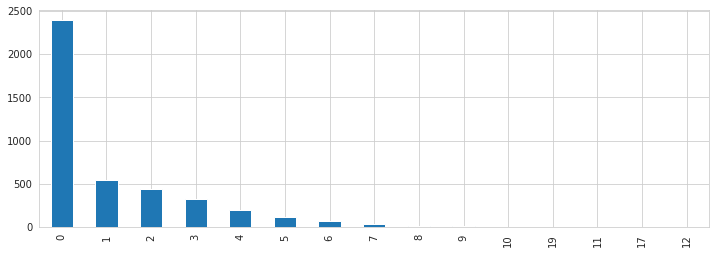

In [44]:
# take a quick look at object counts
y.value_counts().plot(kind='bar', figsize=(12,4));

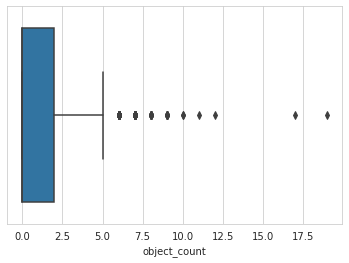

In [47]:
sns.boxplot(x=y);

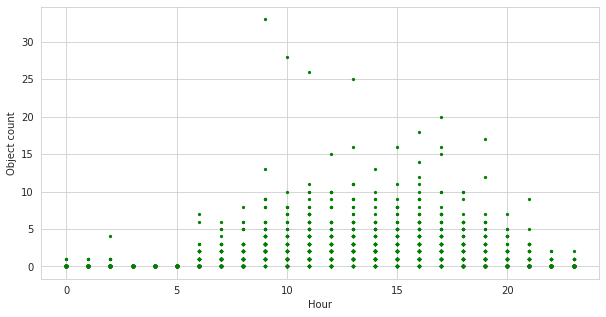

In [162]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(X['hour'], y, s=5, c='g')
ax.set_xlabel('Hour')
ax.set_ylabel('Object count')
plt.show()

### Note:

3 plots above show us that we have some outliers in the dataset.

These were most likely caused by an error in measurement, or just a time interval with abnormal number of objects.

### Z-score

We need a method to identify these outliers statistically and then decide on the action against them (keep, remove or correct).

Wikipedia: The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

Web article: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba:

When calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used

In [163]:
# calculate Z-score
z = np.abs(stats.zscore(y))
print(z[:10])

[0.38659975 0.08573465 0.85893415 0.55806905 0.55806905 1.33126855
 0.08573465 0.08573465 0.38659975 0.55806905]


In [164]:
# identify outliers by Z-score greater than 3
threshold = 3
outliers_idx = np.where(z > threshold)[0]
print(outliers_idx[:5])

[ 38 124 126 130 172]


In [165]:
# show a few outliers
y[outliers_idx[0:4]]

38      9
124     8
126    16
130    20
Name: object_count, dtype: int64

#### Method:

For now we can remove these outliers and later on we can decide if there is a better way of dealing with them. We can also play around with the threshold to see at which point we can treat observations as outliers.

In [166]:
# avg object count before outlier rejection
y.mean()

1.1815126050420168

In [167]:
# keep only values where Z-score is lower than 3
# this will significantly affect the mean of the data
y = y[z < 3]
X = X[z < 3]

In [168]:
# avg object count after outlier rejection
y.mean()

1.0009777560498656

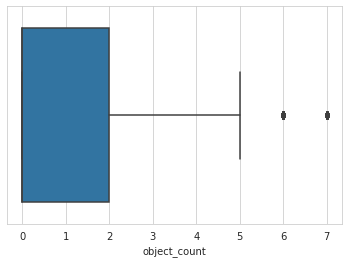

In [175]:
# verify that outliers have been removed on the boxplot
sns.boxplot(x=y);

### Simple averaging model error rates

In [169]:
# create a train/test split for the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=41)

In [170]:
# add back true values, so we can calculate the average for an hour
avg_X_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
mean_obj_counts = avg_X_train.groupby('hour')['object_count'].mean()

In [171]:
# now we can generate the predictions for the test set
y_pred = X_test['hour'].map(mean_obj_counts)

In [173]:
# calculate root mean squared error
r2_score(y_test, y_pred)

0.31451494662183554

In [174]:
# eye-ball a few values
print(np.array(y_test[:5]))
print(np.array(y_pred[:5]))

[0 0 2 1 0]
[0.72477064 0.00892857 0.72477064 0.76106195 0.31775701]


#### Note

At this stage it's difficult to say if this is as good as we can get with the features used. We must try a few other more advanced models and then see if the improvement is actually worth adding the complexity of Machine Learning.

### Sklearn models error rates

#### Method 1: No normalisation, no dummies

In [115]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

2.3647814658049624

In [116]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
reg = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0).fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

2.3657778763127193

In [117]:
from sklearn.svm import SVR
reg = SVR().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

1.9233432696279509

### Note

Based on the results above, all sklearn models are worse than the crude averages model

#### Method 2: Normalisation, no dummies

In [118]:
from sklearn.svm import SVR
from sklearn import preprocessing
reg = SVR().fit(preprocessing.scale(X_train), y_train)
y_pred = reg.predict(preprocessing.scale(X_test))
mean_squared_error(y_test, y_pred, squared=False)

2.016178215229602

In [119]:
from sklearn.svm import SVR
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
reg = SVR().fit(scaler.transform(X_train), y_train)
y_pred = reg.predict(scaler.transform(X_test))
mean_squared_error(y_test, y_pred, squared=False)

2.0082822115940546

#### Method 3: No Normalisation, dummies

In [120]:
# dummies can only be created when features are not-numerical,
# so we can convert those to categorical
X_dum = pd.get_dummies(X.astype('category'))
X_dum.head(2)

,hour_0,hour_2,hour_4,hour_6,hour_8,hour_10,hour_12,hour_14,hour_16,hour_18,hour_20,hour_22,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_in_month_1,week_in_month_2,week_in_month_3,week_in_month_4,week_in_month_5,is_weekend_0,is_weekend_1,month_9,month_10,month_11,month_12
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0


In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dum, y, test_size=0.33, random_state=43)

In [122]:
from sklearn.svm import SVR
reg = SVR().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

1.9254226177982672

### Note

This error rate is quite random and varies quite a bit when **random_state** changes in the train/test split.

We need to change the model or think about additional features to improve the accuracy.

Let's use the best model so far - the SVR model with dummies - and play with the features below.

### Feature selection

Let's try to select individual features and see which combination gives us the best results.

Since error varies a lot based on the random state in train/test split, let's run it for a number of random_states and then take an average of errors.

In [123]:
use_cols = ['hour', 'month', 'is_weekend']

from sklearn.svm import SVR
errors = []
for i in range(64):
    X_train, X_test, y_train, y_test = train_test_split(
        X[use_cols], y, test_size=0.33, random_state=i)
    
    X_train_dum = pd.get_dummies(X_train.astype('category'))
    reg = SVR().fit(X_train_dum, y_train)
    
    X_test_dum = pd.get_dummies(X_test.astype('category'))
    y_pred = reg.predict(X_test_dum)
    y_pred = y_pred.clip(min=0) # make sure no negative predictions are generated
    
    msre = mean_squared_error(y_test, y_pred, squared=False)
    errors.append(msre)
    
np.mean(errors)

1.835129140307776

### TODO:

Let's try to generate a few sample data-points and verify the object count, which the model predicts to see if it all makes sense.

In [124]:
X_test.head(2)

,hour,month,is_weekend
26,12,9,0
1153,10,12,1


In [125]:
use_cols = ['hour', 'month', 'is_weekend']
X_train, X_test, y_train, y_test = train_test_split(
    X[use_cols], y, test_size=0.33, random_state=41)
reg = SVR().fit(X_train, y_train)

points = pd.DataFrame([{'hour': 8, 'month': 9, 'is_weekend': 1}])
y_pred = reg.predict(points)

y_pred

array([1.9696779])

### TODO: 

Define Keras NN and test errors

### TODO:

Define probabilistic model and test errors and uncertainty

### Bring weather data

In [78]:
# bring weather data
weather_df = pd.read_csv('dark_sky_data_2019-09-09_2019-12-26.csv')
weather_df['dt'] = pd.to_datetime(weather_df['dt'])
weather_df.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [126]:
# subtract 30 minutes from the time interval to match with the weather data
resampled['time_interval-30min'] = resampled['time_interval'] - pd.Timedelta(minutes=30)
resampled.head(2)

,time_interval,object_count,hour,week,week_in_month,month,day_of_week,is_weekend,time_interval-60min
0,2019-09-09 08:00:00,5,8,37,2,9,0,0,2019-09-09 07:00:00
1,2019-09-09 10:00:00,1,10,37,2,9,0,0,2019-09-09 09:00:00


In [127]:
resampled.shape 

(1303, 9)

In [129]:
# merge results with weather data
merged = resampled.merge(weather_df, left_on='time_interval-30min', right_on='dt', how='inner')
merged.shape

(0, 29)

In [82]:
# verify correlations between features
merged[['cur__temperature', 'cur__precipProbability', 'day_of_week', 'hour', 'object_count']].corr()

,cur__temperature,cur__precipProbability,day_of_week,hour,object_count
cur__temperature,1.000000,0.133898,-0.030028,0.152799,0.201575
cur__precipProbability,0.133898,1.000000,0.000422,0.053601,-0.084803
day_of_week,-0.030028,0.000422,1.000000,-0.004937,0.071600
hour,0.152799,0.053601,-0.004937,1.000000,0.183218
object_count,0.201575,-0.084803,0.071600,0.183218,1.000000


In [84]:
merged.to_csv('Person_Hourly_preds_with_DarkSky_data.csv', index=False)

### Run sklearn predictions with weather data

In [85]:
X = merged[['hour', 'day_of_week', 'is_weekend', 'month', 'cur__temperature', 'cur__precipProbability', 
            'cur__cloudCover', 'cur__summary', 'cur__precipType', 'cur__windSpeed', 'cur__windGust']]
y = merged['object_count']

###### REMOVE OUTLIERS ######

z = np.abs(stats.zscore(y))
threshold = 3
outliers_idx = np.where(z > threshold)[0]
y = y[z < 3]
X = X[z < 3]

###### SPLIT DATASET INTO TRAIN/TEST ######

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
num_cols = ['cur__temperature', 'cur__precipProbability']
cat_cols = ['hour', 'day_of_week', 'is_weekend', 'month']

###### PREP TRAIN DATA ######

# scale numerical features
from sklearn.preprocessing import StandardScaler
numerical_features = X_train[num_cols]
scaler = StandardScaler()
scaler.fit(numerical_features)
numerical_features_scaled = pd.DataFrame(scaler.transform(numerical_features), columns=num_cols)
# make dummies from categorical features
cat_features = X_train[cat_cols].astype('category')
cat_features_dum = pd.get_dummies(cat_features).reset_index(drop=True)
# concat numerical and dummy features
X_train_concat = pd.merge(numerical_features_scaled, cat_features_dum, left_index=True, right_index=True)

###### PREP TEST DATA ######

numerical_features = X_test[num_cols]
numerical_features_scaled = pd.DataFrame(scaler.transform(numerical_features), columns=num_cols)
# make dummies from categorical features
cat_features = X_test[cat_cols].astype('category')
cat_features_dum = pd.get_dummies(cat_features).reset_index(drop=True)
# concat numerical and dummy features
X_test_concat = pd.merge(numerical_features_scaled, cat_features_dum, left_index=True, right_index=True)

###### TRAIN MODEL / VERIFY ERROR ######

from sklearn.svm import SVR
reg = SVR().fit(X_train_concat, y_train)
y_pred = reg.predict(X_test_concat)
y_pred = y_pred.clip(min=0)
mean_squared_error(y_test, y_pred, squared=False)

1.1799485846104163

### Conclusion

The Machine Learning model is a little bit better than just a crude averages model, however it's not that much better (only a fraction). I think that this will improve when more data is collected.

We should always strive for a simpler solution though, so at this stage choosing plain historical average solution seems to be a better option.

Next, we can try a more complex NN model to see if we can decrease the error rate further. Then we can explore a probabilistic model, which should be able to tell us where the uncertainty occurs and we can think about further improvements then.

In terms of probabilistic models, we can try 2 approaches:
- Poission likelyhood
- Exponential likelyhood

Both have their merits and need to be tried first.